# Outlier Detection

In [0]:
import sys
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import linear_model, datasets
import matplotlib.pyplot as plt
import matplotlib.font_manager
%matplotlib inline
from pyod.models.knn import KNN
from pyod.utils.data import generate_data, get_outliers_inliers
from pyod.models.cblof import CBLOF


## Data Preparation

Here we perform some minor cleaning on the data like converting the required features into proper data type.

In [0]:
data = pd.read_csv('sample_data/scraped_data.csv')

features = ['first_class.catches_taken','first_class.runs']
for feature in features:
    data[feature] = pd.to_numeric(data[feature], errors='coerce') #converting to numeric data
    data[feature] = data[feature].fillna(0) #Filling the invalid characters as 0
    data[feature] = data[feature].astype(int) #Optional Step converting to int64 type


Text(0, 0.5, 'first_class.runs')

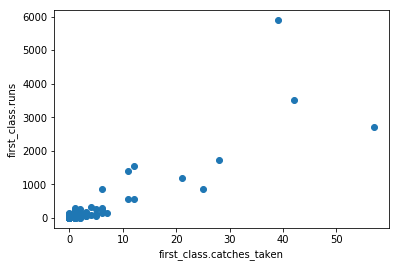

In [8]:
#separate the two features and use it to plot the data 
F1 = np.array(data[features[0]]).reshape(-1,1)
F2 = np.array(data[features[1]]).reshape(-1,1)

# scatter plot 
plt.scatter(F1,F2)
plt.xlabel(features[0])
plt.ylabel(features[1]) 

# k-NN and clustering  based outlier detection

 We us the pyod library for k Nearest Neighbhors kNN and clustering based (CBLOF) classfier.

In [0]:
classifiers = {
     'CBLOF'   : CBLOF(),
     'KNN' :  KNN()
}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


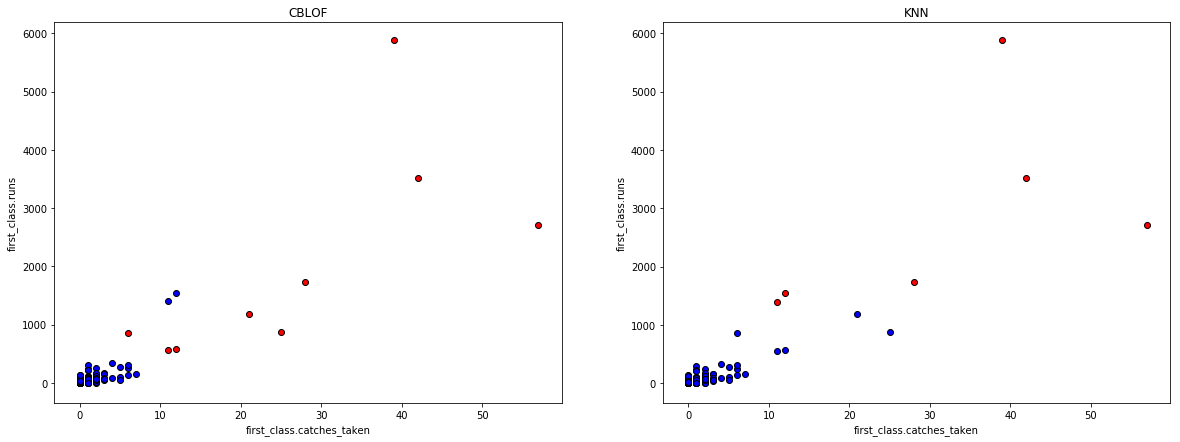

In [10]:
#define Xtrain input for the package based on the features above
X_train = data[features]


#set the figure size
plt.figure(figsize=(20, 7))

for i, (clf_name,clf) in enumerate(classifiers.items()) :
    # fit the dataset to the model
    clf.fit(X_train)

    # predict raw anomaly score
    scores_pred = clf.decision_function(X_train)*-1
    
    # prediction of a datapoint category outlier(1) or inlier(0)
    y_pred = clf.predict(X_train)
    
    X_train['outlier'+str(clf_name)] = y_pred
    
    # get outliers to be shown in red
    allOutliers = X_train[X_train['outlier'+str(clf_name)] == 1]
    Fout1 = np.array(allOutliers[features[0]]).reshape(-1,1)
    Fout2 = np.array(allOutliers[features[1]]).reshape(-1,1)
    
    #get co-ordinates for inliners to be shown in yellow
    allInliners = X_train[X_train['outlier'+str(clf_name)] == 0]
    Fin1 = np.array(allInliners[features[0]]).reshape(-1,1)
    Fin2 = np.array(allInliners[features[1]]).reshape(-1,1)
    
    subplot = plt.subplot(1, 2, i + 1)
    
    subplot.scatter(Fout1,Fout2,c='red', edgecolor='k')
    subplot.scatter(Fin1,Fin2,c='blue', edgecolor='k')
    subplot.set_xlabel(features[0])
    subplot.set_ylabel(features[1]) 
    
    subplot.set_title(clf_name)
    
plt.show() 

# Robust linear model estimation using RANSAC

 In this example we see how to robustly fit a linear model to faulty data using the RANSAC algorithm.

Estimated coefficients (true, linear regression, RANSAC):
[54.17236387] [82.08533159]


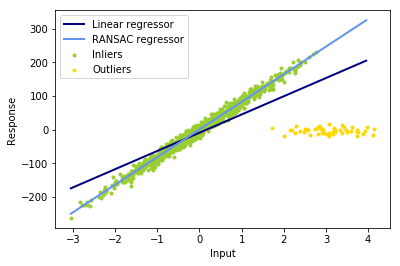

In [11]:
n_samples = 1000
n_outliers = 50


X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Fit line using all data
#X = F1
#y = F2
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(lr.coef_, ransac.estimator_.coef_)

lw = 2
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='upper left')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()